# Logistic Regression Implementation


## Imports

In [1]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Exploring Data  

### Dataset Glossary (Column-wise)
- id (Unique id for each patient)
- age (Age of the patient in years)
- origin (place of study)
- sex (Male/Female)
- cp chest pain type ([typical angina, atypical angina, non-anginal, asymptomatic])
- trestbps resting blood pressure (resting blood pressure (in mm Hg on admission to the hospital))
- chol (serum cholesterol in mg/dl)
- fbs (if fasting blood sugar > 120 mg/dl)
- restecg (resting electrocardiographic results)
- Values: [normal, stt abnormality, lv hypertrophy]
- thalach: maximum heart rate achieved
- exang: exercise-induced angina (True/ False)
- oldpeak: ST depression induced by exercise relative to rest
- slope: the slope of the peak exercise ST segment
- ca: number of major vessels (0-3) colored by fluoroscopy
- thal: [normal; fixed defect; reversible defect]
- num: the predicted attribute


Text(0.5, 1.0, 'Correlation Heatmap')

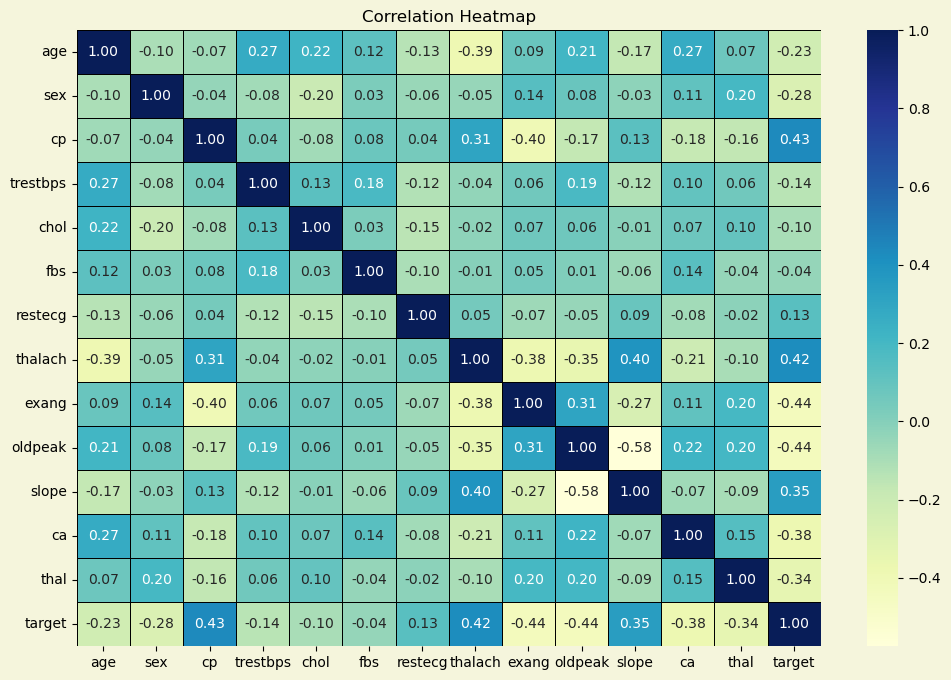

In [2]:
df = pd.read_csv('../datasets/report.csv')
plt.figure(figsize=(12, 8), facecolor='beige')
# sns.heatmap(df.corr(), annot=True,  cmap=sns.dark_palette("#00eaff", as_cmap=True))
sns.heatmap(df.corr(), annot=True, linewidth=0.5,  fmt=".2f",  cmap="YlGnBu", linecolor="black")
plt.title("Correlation Heatmap")

In [3]:
pd.crosstab(df.target, df.sex)

sex,0,1
target,,
0,86,413
1,226,300


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

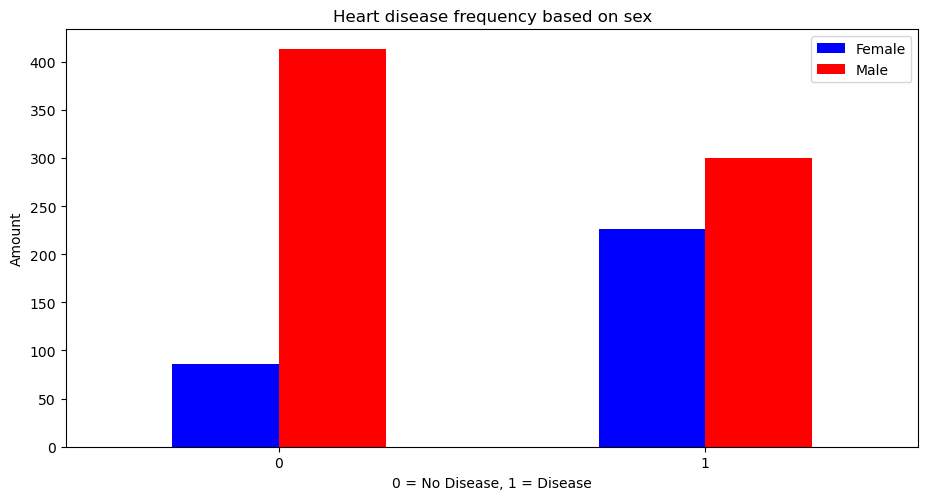

In [4]:

pd.crosstab(df.target, df.sex).plot(kind="bar", figsize=(11, 5.42), color=["blue", "red"])
plt.title("Heart disease frequency based on sex")
plt.xlabel("0 = No Disease, 1 = Disease")
plt.ylabel("Amount")
plt.legend(["Female", "Male"])
plt.xticks(rotation=0)

In [5]:



df.isna().sum() # No NUll values
df.describe()
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


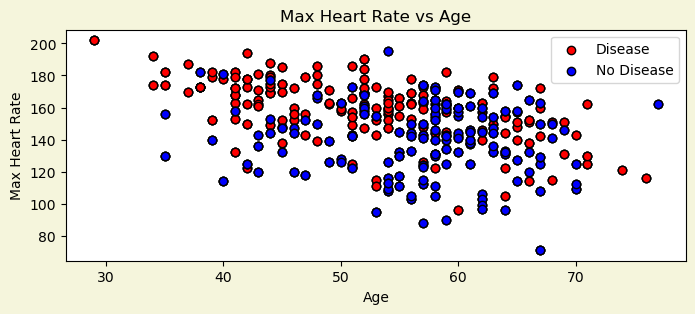

In [6]:
# Scatter with positive examples
plt.figure(figsize=(8, 3), facecolor='beige', edgecolor='white')
plt.xlabel("Age")
plt.ylabel("Max Heart Rate")
plt.title("Max Heart Rate vs Age")
plt.scatter(df.age[df.target == 1], df.thalach[df.target == 1], c="red", edgecolors="black")

# Scatter with negative examples
plt.scatter(df.age[df.target ==  0], df.thalach[df.target ==0], c="blue", edgecolors="black")
plt.legend(["Disease", "No Disease"])

<Axes: title={'center': 'Age Distribution'}, ylabel='Frequency'>

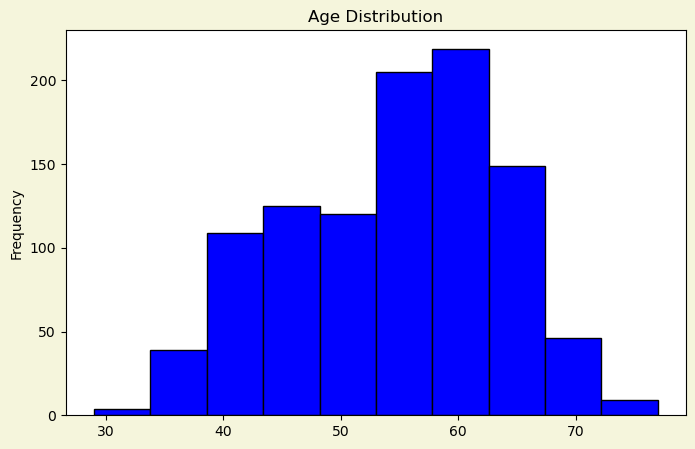

In [7]:
plt.figure(figsize=(8, 5), facecolor='beige', edgecolor='white')
plt.title("Age Distribution")
plt.xlabel("Age")
df.age.plot.hist(facecolor="blue", edgecolor="black") 

## Preprocessing

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)
print("Number of outliers:", outliers.sum())
# Removing outliers using IQR
def remove_outliers_iqr(data, column_name):
    Q1 = data[column_name].quantile(0.25)  # First quartile
    Q3 = data[column_name].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1                          # Interquartile range
    
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter data
    data = data[(data[column_name] >= lower_bound) & (data[column_name] <= upper_bound)]
    return data

# Example: Remove outliers in the "rm" column
df = remove_outliers_iqr(df, "target")

X = df.drop("target", axis=1)
Y = df.target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#Scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Number of outliers: 256


In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def classify(x, weights, bias):
    sigmoid_values = sigmoid(np.dot(x, weights) + bias)

    return np.where(sigmoid_values >= 0.5, 1, 0)
    
     
def cost_function(actual, predicted):
        epsilon = 1e-15
        predicted = np.clip(predicted, epsilon, 1 - epsilon)
        m = len(actual)
        return -1/m * np.sum(np.dot(actual , np.log(predicted)) + np.dot((1 - actual) , np.log(1 - predicted)))

# Gradient descent for minimizing cost function
def gradient_descent(num_features, predicted_values, actual_values, learning_rate, weights, bias):
    n = len(num_features)
    weight_gradient = -2/ n * np.dot(num_features.T, (actual_values - predicted_values))
    bias_gradient = -2 / n * np.sum(actual_values - predicted_values)
    
    weights = weights - learning_rate * weight_gradient
    bias = bias - learning_rate * bias_gradient
    return weights, bias



## Train the model

In [10]:
num_features = X_train.shape[1]
epochs = 1000
weights = np.zeros(num_features)
bias = 0
learning_rate = 0.001

for i in range(epochs):
    predicted_values = sigmoid(np.dot(X_train, weights) + bias)
    cost = cost_function(Y_train, predicted_values)
    weights, bias = gradient_descent(X_train, predicted_values, Y_train, learning_rate, weights, bias)
    
    if i % 100 == 0:
        print(f"Epoch {i}: Cost = {cost_function(Y_train, predicted_values)}")



Epoch 0: Cost = 0.6931471805599447
Epoch 100: Cost = 0.6338003830975449
Epoch 200: Cost = 0.5879302508575053
Epoch 300: Cost = 0.5520618742402836
Epoch 400: Cost = 0.5236035349925872
Epoch 500: Cost = 0.5006763754909151
Epoch 600: Cost = 0.48192885499703797
Epoch 700: Cost = 0.4663850633507614
Epoch 800: Cost = 0.45333334214471793
Epoch 900: Cost = 0.44224807516665926


# Run the model

In [11]:

result = classify(X_test, weights, bias)

# Evaluate the model

Accuracy: 77.07317073170732%
Recall: 87.37864077669903%
Precision: 72.58064516129032%
F1 Score: 79.29515418502203%


Text(0.5, 1.0, 'ROC Curve')

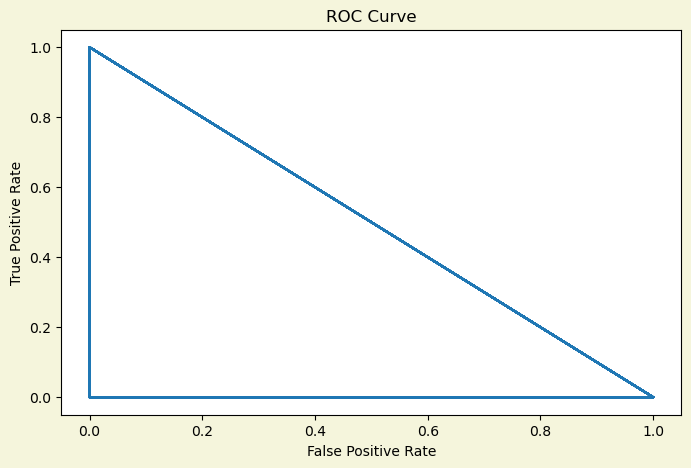

In [12]:
accuaracy = (result == Y_test).sum() / len(Y_test)
print(f"Accuracy: {accuaracy * 100}%")

recall = np.sum((result == 1) & (Y_test == 1)) / np.sum(Y_test == 1)
print(f"Recall: {recall * 100}%")

precision = np.sum((result == 1) & (Y_test == 1)) / np.sum(result == 1)
print(f"Precision: {precision * 100}%")


f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {f1_score * 100}%")

#ROC Curve
plt.figure(figsize=(8, 5), facecolor='beige', edgecolor='white')
plt.plot(((result == 1) & (Y_test == 0)), ((result == 1) & (Y_test == 1)) )
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

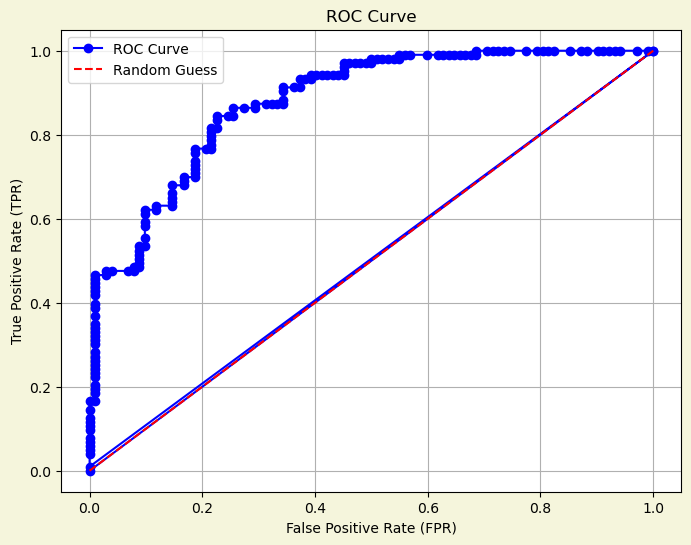

In [13]:
# Generate predicted probabilities for the test set
y_pred_probs = sigmoid(np.dot(X_test, weights) + bias)

# Sort the unique predicted probabilities
thresholds = np.sort(np.unique(y_pred_probs))

tpr_values = []  # True Positive Rate
fpr_values = []  # False Positive Rate

# Calculate TPR and FPR for each threshold
for threshold in thresholds:
    # Classify predictions based on the current threshold
    y_pred_threshold = (y_pred_probs >= threshold).astype(int)
    
    # True Positives, False Positives, True Negatives, False Negatives
    TP = np.sum((y_pred_threshold == 1) & (Y_test == 1))
    FP = np.sum((y_pred_threshold == 1) & (Y_test == 0))
    TN = np.sum((y_pred_threshold == 0) & (Y_test == 0))
    FN = np.sum((y_pred_threshold == 0) & (Y_test == 1))
    
    # Calculate TPR and FPR
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0
    
    tpr_values.append(TPR)
    fpr_values.append(FPR)

# Add points (0,0) and (1,1) to the curve for completion
tpr_values = [0] + tpr_values + [1]
fpr_values = [0] + fpr_values + [1]

# Plot the ROC curve
plt.figure(figsize=(8, 6), facecolor='beige')
plt.plot(fpr_values, tpr_values, marker='o', color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()
